In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load Datasets
train_dir = "D:/Singularity101/Dataset_Preprocessed/train"
val_dir = "D:/Singularity101/Dataset_Preprocessed/val"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset info
print(f"Class Labels: {train_dataset.classes}")
print(f"Train Set Size: {len(train_dataset)} images")
print(f"Validation Set Size: {len(val_dataset)} images")

Class Labels: ['Fake', 'Real']
Train Set Size: 2800 images
Validation Set Size: 600 images


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetLSTM(nn.Module):
    def __init__(self, hidden_dim=512, num_layers=1, num_classes=1):
        super(ResNetLSTM, self).__init__()

        # Load pre-trained ResNet50 (Fixed: Use recommended weights)
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Remove last fully connected layer
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])  # Keep conv features

        # Adaptive pooling to ensure fixed-size output
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  

        # LSTM for sequence processing
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.shape  # (Batch, TimeSteps, C, H, W)

        # Reshape input: (Batch * TimeSteps, C, H, W) for batch processing
        x = x.view(batch_size * seq_len, c, h, w)

        # Extract features using ResNet (Faster than loop)
        x = self.resnet_features(x)  # (Batch * TimeSteps, 2048, H', W')
        x = self.avgpool(x)  # (Batch * TimeSteps, 2048, 1, 1)
        x = x.view(batch_size, seq_len, -1)  # Reshape to (Batch, TimeSteps, 2048)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)

        # Take last LSTM output
        output = self.fc(lstm_out[:, -1, :])  # (Batch, num_classes)

        return output

# Check Model Architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetLSTM().to(device)
print(model)

ResNetLSTM(
  (resnet_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [4]:
class_weights = torch.tensor([1.0, 1.5]).to(device)  # Tune this value
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=5, mode="triangular2")

# BEP

In [5]:
num_epochs = 50  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        images = images.unsqueeze(1)  # Add sequence dimension
        outputs = model(images)
        
        loss = criterion(outputs, labels.float().unsqueeze(1))  # Ensure labels match output shape
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/50], Loss: 0.8324
Epoch [2/50], Loss: 0.6983
Epoch [3/50], Loss: 0.5385
Epoch [4/50], Loss: 0.3956
Epoch [5/50], Loss: 0.2331
Epoch [6/50], Loss: 0.0935
Epoch [7/50], Loss: 0.0435
Epoch [8/50], Loss: 0.0237
Epoch [9/50], Loss: 0.0200
Epoch [10/50], Loss: 0.0105
Epoch [11/50], Loss: 0.0070
Epoch [12/50], Loss: 0.0074
Epoch [13/50], Loss: 0.0022
Epoch [14/50], Loss: 0.0013
Epoch [15/50], Loss: 0.0045
Epoch [16/50], Loss: 0.0028
Epoch [17/50], Loss: 0.0071
Epoch [18/50], Loss: 0.0016
Epoch [19/50], Loss: 0.0085
Epoch [20/50], Loss: 0.0009
Epoch [21/50], Loss: 0.0007
Epoch [22/50], Loss: 0.0049
Epoch [23/50], Loss: 0.0021
Epoch [24/50], Loss: 0.0005
Epoch [25/50], Loss: 0.0008
Epoch [26/50], Loss: 0.0031
Epoch [27/50], Loss: 0.0003
Epoch [28/50], Loss: 0.0058
Epoch [29/50], Loss: 0.0009
Epoch [30/50], Loss: 0.0003
Epoch [31/50], Loss: 0.0056
Epoch [32/50], Loss: 0.0002
Epoch [33/50], Loss: 0.0002
Epoch [34/50], Loss: 0.0014
Epoch [35/50], Loss: 0.0087
Epoch [36/50], Loss: 0.0001
E

In [6]:
for images, labels in train_loader:
    print(labels[:10])  # Check first 10 labels
    break

tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 1])


In [7]:
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device).float()
    images = images.unsqueeze(1)  # Ensure shape is (Batch, TimeSteps=1, C, H, W)
    
    outputs = model(images)
    print(outputs[:10])  # Check first 10 outputs
    break

tensor([[  9.2657],
        [-11.4235],
        [  7.4926],
        [  9.6913],
        [  5.7407],
        [  8.3859],
        [  6.3817],
        [  9.6917],
        [  9.1599],
        [  4.2023]], device='cuda:0', grad_fn=<SliceBackward0>)


In [8]:
for param in model.parameters():
    print(param.abs().mean().item())  # Check weight magnitude
    break

0.1562119573354721


In [9]:
torch.save(model.state_dict(), "resnet_lstm_model.pth")

In [10]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def test_model(model, data_loader, device):
    model.eval()  
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.unsqueeze(1)  

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    return np.array(all_labels), np.array(all_preds)

In [11]:
# Run evaluation
true_labels, pred_labels = test_model(model, val_loader, device)

# Compute Metrics
accuracy = accuracy_score(true_labels, pred_labels)
conf_matrix = confusion_matrix(true_labels, pred_labels)
class_report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.6683
Confusion Matrix:
 [[200 100]
 [ 99 201]]

Classification Report:
               precision    recall  f1-score   support

        Fake       0.67      0.67      0.67       300
        Real       0.67      0.67      0.67       300

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600



In [12]:
from PIL import Image
import torchvision.transforms as transforms

# Load image
image_path = "frame_006.jpg"
image = Image.open(image_path).convert("L")  # Convert to grayscale

# Define transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Preprocess image
image = transform(image).unsqueeze(0).unsqueeze(0).to(device)  # Add batch & sequence dim

# Get prediction
model.eval()
with torch.no_grad():
    output = model(image)
    prediction = torch.sigmoid(output).item()
    label = "Real" if prediction > 0.5 else "Fake"

print(f"Predicted Label: {label} (Confidence: {prediction:.4f})")

Predicted Label: Fake (Confidence: 0.0000)


Accuracy: 0.6683

Classification Report:
              precision    recall  f1-score   support

        Fake       0.67      0.67      0.67       300
        Real       0.67      0.67      0.67       300

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600



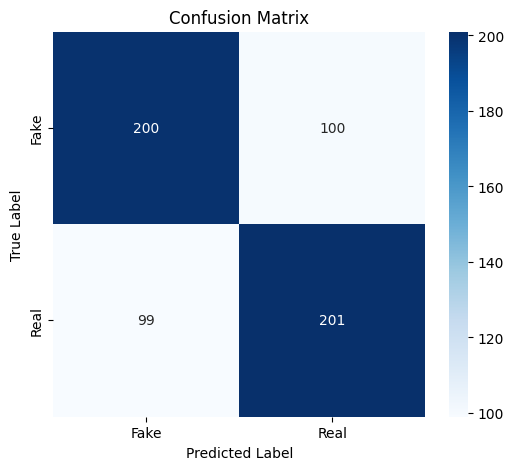

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Plot confusion matrix as an image
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    
    # Save the image
    plt.savefig("confusion_matrix.png")
    plt.show()

def test_and_plot_conf_mat(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.unsqueeze(1)  # Add sequence dimension

            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds = (preds > 0.5).int()  # Convert probabilities to binary labels

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert to NumPy arrays
    true_labels, pred_labels = np.array(all_labels), np.array(all_preds)
    
    # Compute accuracy
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=['Fake', 'Real']))

    # Plot and save confusion matrix
    plot_confusion_matrix(true_labels, pred_labels, class_names=['Fake', 'Real'])

# Call the function to test and visualize
test_and_plot_conf_mat(model, val_loader, device)